# Lab 4
Author: Ksenofontov Gregory

Compare [optimal brain damage](https://proceedings.neurips.cc/paper/1989/file/6c9882bbac1c7093bd25041881277658-Paper.pdf) procdure using diagonal hessian and full-rank hessian. 
*   Model: linear regression model.
*   Data: simple dataset (not more than 50 variables).
*   Plot: dependence of the model performance on the number of removed features.

### Theory

To find parameter to remove we can measure the difference of a losses $\Delta L$ of loss with zeroed parameter $L({\bf w} + \Delta {\bf w})$ and not-zeroed parameter loss $L({\bf w})$. To find it we approximate the objective function $L$ by a Taylor series at the otimized parameters ${\bf w}$ $$L({\bf w} + \Delta {\bf w}) = L({\bf w}) + {\bf g}^T\Delta {\bf w} + \frac12\Delta {\bf w}^T{\bf H}\Delta {\bf w} + \dots$$

First term ${\bf g}^T\Delta {\bf w}$ can be removed, because the training has converged

So, for full-rank Hessian $\Delta L$ is
$$\Delta L = L({\bf w} + \Delta {\bf w}) - L({\bf w}) = \frac12\Delta {\bf w}^T{\bf H}\Delta {\bf w} = \frac12\sum_{i, j}h_{ij}\Delta w_i\Delta w_j$$
And if Hessian is diagonal, $\Delta L$ is
$$\Delta L = \frac12\sum_{i}h_{ii}\Delta w_i^2$$

Having such equasions, we can measure the impact (salience) of the parameters, for full-rank and diagonal Hessian, respectively
$$s_k = \frac12\sum_{j}h_{kj} w_k w_j$$
$$s_k = \frac12h_{kk} w_k^2$$


Choosing $N$ parameters with lowest saliences, we can remove them with lowest impact on loss function.

### Implemetation
Imports and global parameters

In [315]:
!pip install flax optax distrax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [316]:
import jax.numpy as jnp
from jax import random, grad, jit, hessian

import optax

import matplotlib.pyplot as plt
from tqdm import tqdm

In [317]:
SEED = random.PRNGKey(42)
features = 99
train_size = 25
data_noise = 1

In [318]:
def plot_grid(values, x_scale=1):
    plt.grid()
    X = jnp.linspace(0, len(values) * x_scale, len(values))
    plt.plot(X, values)
    plt.show()

Generating the data

In [319]:
X = jnp.concatenate([random.normal(SEED, shape=(train_size, features)), jnp.ones((train_size, 1))], axis=1)
W_true = random.normal(SEED, shape=(features + 1, 1))
Y = X @ W_true + data_noise * random.normal(SEED, shape=(train_size, 1))

In [320]:
print(jnp.linalg.det(X.T @ X))

W = jnp.linalg.inv(X.T @ X) @ X.T @ Y
((W - W_true)**2).mean()

-0.0


Array(52295.777, dtype=float32)

With a large number of parameters, the determinant is close to zero, so we will optimize the model using SGD

In [321]:
class LinearRegression:

  def predict(self, W, X):
      return jnp.dot(X, W)

  # Training loss is MSE
  def criterion(self, W, X, Y):
      preds = self.predict(W, X)
      return jnp.mean((preds - Y)**2)

linear = LinearRegression()

In [322]:
def fit(model, epochs, W, optimizer, mask, verbose=True):
      losses = []
      W *= mask
      opt_state = optimizer.init(W)

      @jit
      def step(batch, W, opt_state):
        loss = model.criterion(W, batch[0], batch[1])
        grad_loss = grad(model.criterion)
        grads = grad_loss(W, batch[0], batch[1]).mean(0)
        updates, opt_state = optimizer.update(grads, opt_state, W)
        W = optax.apply_updates(W, updates)
        return W * mask, opt_state, loss

      for epoch in range(1, epochs + 1):
        avg_loss = 0
        for i, batch in enumerate(zip(X, Y)):
          W, opt_state, loss = step(batch, W, opt_state)
          avg_loss += loss
        losses.append(avg_loss/(i+1))
        if verbose and epoch % 20 == 0: # Print loss every 20 epochs
          print(f"epoch: {epoch}, loss: {avg_loss.mean():.8f}")
      return W * mask, losses

In [323]:
f = lambda W: linear.criterion(W, X, Y)
H = X.T @ X

AxesSubplot(0.125,0.125;0.62x0.755)
-0.2837785
-3.1247406
-0.0687747


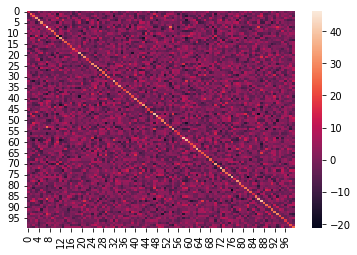

In [335]:
import seaborn as sns

print(sns.heatmap(H))
print(H[0][1:].mean())
print((H[1][0] + H[1][2:].mean())/2)
print((H[2][:2].mean() + H[1][3:].mean())/2)

In [325]:
hyper_params =[
    (5e-4, 20),
    (1e-2, 5),
    (1e-2, 20),
    (1e-2, 10),
    (1e-3, 30),
    (1e-2, 20),
    (5e-3, 20),
    (1e-2, 20),
    (1e-2, 20),
    (1e-2, 20),
]

# N - amount parameters to remove in each step
N = int((features + 1) / (len(hyper_params)))

In [326]:
errors_full_rank = []
mask = jnp.ones((features + 1,))
W_start = random.normal(SEED, (features + 1,))

for step, (lr, epochs) in enumerate(hyper_params):
    # Init params and optimizer
    W = W_start
    optimizer = optax.adam(learning_rate=lr)

    # Train model with specific mask
    W, losses = fit(linear, epochs, W, optimizer, mask, verbose=False)
    errors_full_rank.append(losses[-1].item())
    
    # Computing saliences
    saliences = []
    for w_num in range(W.shape[0]):
        saliences.append((W * H[w_num]).sum())
    saliences = jnp.stack(saliences) * W
    if step == 4:
        saliences_full_rank = saliences

    # Finding N parameters with the smallest saliences
    idx = saliences.argsort()

    # Check if parameter is not removed
    for i in range(N):
      for w_remove in range(W.shape[0]):
        if mask[w_remove] == 1:
            break
      # Remove parameter
      mask -= jnp.eye(1, mask.shape[0], w_remove).squeeze()

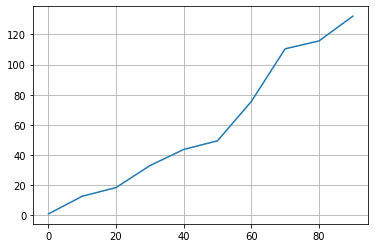

In [327]:
plot_grid(errors_full_rank, x_scale=N - 1)

In [328]:
hyper_params =[
    (1e-2, 15),
    (1e-3, 10),
    (1e-3, 15),
    (1e-3, 15),
    (1e-3, 15),
    (1e-3, 15),
    (1e-3, 15),
    (1e-3, 15),
    (1e-3, 15),
    (1e-3, 10),
]

In [329]:
errors_diag = []
mask = jnp.ones((features + 1,))
W_start = random.normal(SEED, (features + 1,))

for step, (lr, epochs) in enumerate(hyper_params):
    # Init params and optimizer
    optimizer = optax.adam(learning_rate=lr)
    W = W_start

    # Train model with specific mask
    W, losses = fit(linear, epochs, W, optimizer, mask, verbose=False)
    errors_diag.append(losses[-1].item())
    
    # Computing saliences
    saliences = W**2 * jnp.diag(H)
    if step == 4:
        saliences_diag = saliences
    # Finding N parameters with the smallest saliences
    idx = saliences.argsort()
    # Check if parameter is not removed
    for i in range(N):
      for w_remove in range(W.shape[0]):
        if mask[w_remove] == 1:
            break
      # Remove parameter
      mask -= jnp.eye(1, mask.shape[0], w_remove).squeeze()

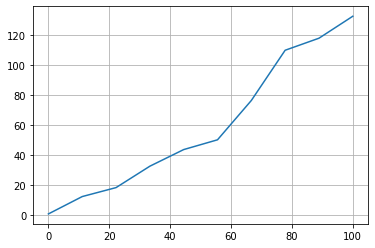

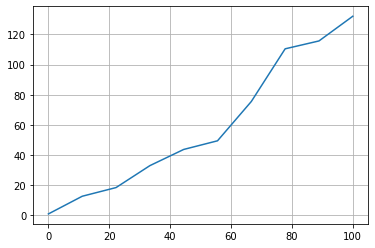

In [330]:
plot_grid(errors_diag, x_scale=N)
plot_grid(errors_full_rank, x_scale=N)

In [331]:
jnp.isclose(saliences_full_rank, saliences_diag)

Array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False], dtype=bool)

## Conclusions
Because of calculated Hessian is diagonal matrix, results with full-rank and diagonal Hessian are almost the same.